## Try out different classifiers to predict Titanic survival

### Get packages & data

In [1]:
# get packages

import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# show matplotlib plots nicely
%matplotlib inline

In [2]:
# get data

from sklearn.datasets import fetch_openml
titanic = fetch_openml('titanic', version=1, as_frame=True)

## Inspect data

In [3]:
display(titanic.data.head())
display(titanic.target.head())

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): [0, 1]

In [4]:
type(titanic)

sklearn.utils.Bunch

In [5]:
titanic.keys()
# boom

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
titanic.target_names

['survived']

In [7]:
titanic.data.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [8]:
titanic.data["ticket"].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: ticket, dtype: object

In [9]:
titanic.data['ticket'].head(10)

0       24160
1      113781
2      113781
3      113781
4      113781
5       19952
6       13502
7      112050
8       11769
9    PC 17609
Name: ticket, dtype: object

In [10]:
titanic.data.ticket.value_counts()

CA. 2343             11
CA 2144               8
1601                  8
347082                7
347077                7
                     ..
C.A. 29178            1
SOTON/O.Q. 392087     1
SC/A.3 2861           1
364500                1
211536                1
Name: ticket, Length: 929, dtype: int64

In [11]:
titanic.data['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [12]:
titanic.data["sibsp"].head(10)
# siblings / partners

0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    0.0
6    1.0
7    0.0
8    2.0
9    0.0
Name: sibsp, dtype: float64

In [13]:
titanic.data.parch.head(10)
# parents / children

0    0.0
1    2.0
2    2.0
3    2.0
4    2.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: parch, dtype: float64

In [14]:
titanic.data['cabin'].head(10)

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
5        E12
6         D7
7        A36
8       C101
9       None
Name: cabin, dtype: object

In [15]:
titanic.data['boat'].head(10)
# boat = Lifeboat (if survived)

0       2
1      11
2    None
3    None
4    None
5       3
6      10
7    None
8       D
9    None
Name: boat, dtype: object

In [16]:
titanic.data['body'].nunique()
# body = Body number (if did not survive and body was recovered)

121

In [17]:
titanic.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


## Data cleaning & feature engineering

1. Merge Titanic X and y data before manipulating things
1. Features to keep: pclass, sex, age, sibsp, parch, ticket, fare (use name as the index?)
1. Features to fiddle with:
    1. pclass => one-hot encode
    1. sex => one-hot encode
    1. age => fill na
    1. fare => create fare per person, ie fare divided by instances of it's corresponding ticket

In [18]:
# merge titanic data and titanic target (ie X and y)
titanic_full = pd.concat([titanic.data, titanic.target.reindex(titanic.data.index)], axis=1)
titanic_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.7+ KB


In [19]:
# use name column for indexing
titanic_full.set_index('name', inplace=True)
titanic_full.head(3)

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
name,,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",1.0,female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
"Allison, Master. Hudson Trevor",1.0,male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
"Allison, Miss. Helen Loraine",1.0,female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


In [20]:
# check missing values for age
titanic_full['age_is_missing'] = titanic_full['age'].isnull()
titanic_full['age_is_missing'].value_counts()

False    1046
True      263
Name: age_is_missing, dtype: int64

In [21]:
## fill in missing age values with mediam age

# median age
med_age = titanic_full['age'].quantile(0.5)
print(med_age)

# replace null values with med_age
titanic_full['age'].fillna(med_age, inplace=True)

# how many isnull values do we now have for age (hopefully, zero)
titanic_full['age'].isnull().sum()

28.0


0

In [22]:
# one-hot encode pclass & sex
class_dummies = pd.get_dummies(titanic_full['pclass'], prefix='pclass')
display(class_dummies)

sex_dummies = pd.get_dummies(titanic_full['sex'], prefix='sex')

titanic_dummies = pd.concat([titanic_full, class_dummies, sex_dummies], axis=1)
titanic_dummies.drop(
    ["pclass", "sex", "cabin", "embarked", "boat", "body", "home.dest", "age_is_missing"], axis=1, inplace=True)
display(titanic_dummies)

,pclass_1.0,pclass_2.0,pclass_3.0
name,,,
"Allen, Miss. Elisabeth Walton",1,0,0
"Allison, Master. Hudson Trevor",1,0,0
"Allison, Miss. Helen Loraine",1,0,0
"Allison, Mr. Hudson Joshua Creighton",1,0,0
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,0,0
...,...,...,...
"Zabour, Miss. Hileni",0,0,1
"Zabour, Miss. Thamine",0,0,1
"Zakarian, Mr. Mapriededer",0,0,1


,age,sibsp,parch,ticket,fare,survived,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male
name,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",29.0000,0.0,0.0,24160,211.3375,1,1,0,0,1,0
"Allison, Master. Hudson Trevor",0.9167,1.0,2.0,113781,151.5500,1,1,0,0,0,1
"Allison, Miss. Helen Loraine",2.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0
"Allison, Mr. Hudson Joshua Creighton",30.0000,1.0,2.0,113781,151.5500,0,1,0,0,0,1
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
"Zabour, Miss. Hileni",14.5000,1.0,0.0,2665,14.4542,0,0,0,1,1,0
"Zabour, Miss. Thamine",28.0000,1.0,0.0,2665,14.4542,0,0,0,1,1,0
"Zakarian, Mr. Mapriededer",26.5000,0.0,0.0,2656,7.2250,0,0,0,1,0,1


In [23]:
# inspect
titanic_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, Allen, Miss. Elisabeth Walton to Zimmerman, Mr. Leo
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         1309 non-null   float64 
 1   sibsp       1309 non-null   float64 
 2   parch       1309 non-null   float64 
 3   ticket      1309 non-null   object  
 4   fare        1308 non-null   float64 
 5   survived    1309 non-null   category
 6   pclass_1.0  1309 non-null   uint8   
 7   pclass_2.0  1309 non-null   uint8   
 8   pclass_3.0  1309 non-null   uint8   
 9   sex_female  1309 non-null   uint8   
 10  sex_male    1309 non-null   uint8   
dtypes: category(1), float64(4), object(1), uint8(5)
memory usage: 69.1+ KB


In [24]:
# fare has one null value => drop that row
titanic_dummies.dropna(subset=['fare'], inplace=True)
titanic_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, Allen, Miss. Elisabeth Walton to Zimmerman, Mr. Leo
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         1308 non-null   float64 
 1   sibsp       1308 non-null   float64 
 2   parch       1308 non-null   float64 
 3   ticket      1308 non-null   object  
 4   fare        1308 non-null   float64 
 5   survived    1308 non-null   category
 6   pclass_1.0  1308 non-null   uint8   
 7   pclass_2.0  1308 non-null   uint8   
 8   pclass_3.0  1308 non-null   uint8   
 9   sex_female  1308 non-null   uint8   
 10  sex_male    1308 non-null   uint8   
dtypes: category(1), float64(4), object(1), uint8(5)
memory usage: 69.1+ KB


In [25]:
# calculate fare per person for multi-people ticket

# group by ticket, then calculate the length of each group and assign that value to a new column "ticket_count"
titanic_dummies['ticket_count'] = (
    titanic_dummies.groupby("ticket")['ticket'].transform(len))

titanic_dummies.head()

,age,sibsp,parch,ticket,fare,survived,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,ticket_count
name,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",29.0000,0.0,0.0,24160,211.3375,1,1,0,0,1,0,4
"Allison, Master. Hudson Trevor",0.9167,1.0,2.0,113781,151.5500,1,1,0,0,0,1,6
"Allison, Miss. Helen Loraine",2.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6
"Allison, Mr. Hudson Joshua Creighton",30.0000,1.0,2.0,113781,151.5500,0,1,0,0,0,1,6
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6


In [26]:
titanic_dummies['ticket_count'].describe()
# seems to work? yay?

count    1308.000000
mean        2.102446
std         1.780252
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        11.000000
Name: ticket_count, dtype: float64

In [27]:
titanic_dummies['ticket'].value_counts()
# just checking

CA. 2343             11
CA 2144               8
1601                  8
S.O.C. 14879          7
PC 17608              7
                     ..
C.A. 29178            1
SOTON/O.Q. 392087     1
SC/A.3 2861           1
364500                1
211536                1
Name: ticket, Length: 928, dtype: int64

In [28]:
titanic_dummies['fare_per_person'] = titanic_dummies['fare'] / titanic_dummies['ticket_count']
titanic_dummies.head()

,age,sibsp,parch,ticket,fare,survived,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,ticket_count,fare_per_person
name,,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",29.0000,0.0,0.0,24160,211.3375,1,1,0,0,1,0,4,52.834375
"Allison, Master. Hudson Trevor",0.9167,1.0,2.0,113781,151.5500,1,1,0,0,0,1,6,25.258333
"Allison, Miss. Helen Loraine",2.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6,25.258333
"Allison, Mr. Hudson Joshua Creighton",30.0000,1.0,2.0,113781,151.5500,0,1,0,0,0,1,6,25.258333
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6,25.258333


In [29]:
# inspect
titanic_dummies['fare_per_person'].describe()

count    1308.000000
mean       14.757627
std        13.555638
min         0.000000
25%         7.550000
50%         8.050000
75%        15.008325
max       128.082300
Name: fare_per_person, dtype: float64

In [30]:
# clip fare per person
from math import sqrt

titanic_dummies['sqrt_fare_pp'] = titanic_dummies['fare_per_person'].apply(lambda value:sqrt(value))
titanic_dummies.head()

,age,sibsp,parch,ticket,fare,survived,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,ticket_count,fare_per_person,sqrt_fare_pp
name,,,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",29.0000,0.0,0.0,24160,211.3375,1,1,0,0,1,0,4,52.834375,7.268726
"Allison, Master. Hudson Trevor",0.9167,1.0,2.0,113781,151.5500,1,1,0,0,0,1,6,25.258333,5.025767
"Allison, Miss. Helen Loraine",2.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6,25.258333,5.025767
"Allison, Mr. Hudson Joshua Creighton",30.0000,1.0,2.0,113781,151.5500,0,1,0,0,0,1,6,25.258333,5.025767
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1.0,2.0,113781,151.5500,0,1,0,0,1,0,6,25.258333,5.025767


In [31]:
# drop ticket, fare, unclipped fare_per_person
titanic_dummies.drop(['ticket', 'ticket_count', 'fare', 'fare_per_person'], axis=1, inplace=True)
titanic_dummies.head()

,age,sibsp,parch,survived,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,sqrt_fare_pp
name,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",29.0000,0.0,0.0,1,1,0,0,1,0,7.268726
"Allison, Master. Hudson Trevor",0.9167,1.0,2.0,1,1,0,0,0,1,5.025767
"Allison, Miss. Helen Loraine",2.0000,1.0,2.0,0,1,0,0,1,0,5.025767
"Allison, Mr. Hudson Joshua Creighton",30.0000,1.0,2.0,0,1,0,0,0,1,5.025767
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1.0,2.0,0,1,0,0,1,0,5.025767


### Consider the different algorithms I may use

1) Trees <br>
Model: Decision tree, gradient boosted decision tree, random forest <br>
Data prep: deal with missing values


2) knn <br>
Model: k-nearest neighbours <br>
Data prep: deal with missing values, convert categorical variables to numeric


3) Linear models <br>
Models: Logistic regression & Support vector machine <br>
Data prep: deal with missing values, convert categorical variables to numeric


### Prepare the data

In [32]:
# inspect data (eg waht's the range of values in each column, how many empty cells for each column)

display(titanic_dummies.describe())
display(titanic_dummies.info())
# => all seems good
# (though as we've seen, sometimes you can have, eg, a single null value somewhere
# => need to actually look at the descriptors)

,age,sibsp,parch,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,sqrt_fare_pp
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,29.479485,0.499235,0.385321,0.246942,0.211774,0.541284,0.356269,0.643731,3.560072
std,12.881658,1.041965,0.865826,0.431398,0.408722,0.498483,0.479079,0.479079,1.443990
min,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.747726
50%,28.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.837252
75%,35.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.874058
max,80.000000,8.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.317345


<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, Allen, Miss. Elisabeth Walton to Zimmerman, Mr. Leo
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           1308 non-null   float64 
 1   sibsp         1308 non-null   float64 
 2   parch         1308 non-null   float64 
 3   survived      1308 non-null   category
 4   pclass_1.0    1308 non-null   uint8   
 5   pclass_2.0    1308 non-null   uint8   
 6   pclass_3.0    1308 non-null   uint8   
 7   sex_female    1308 non-null   uint8   
 8   sex_male      1308 non-null   uint8   
 9   sqrt_fare_pp  1308 non-null   float64 
dtypes: category(1), float64(4), uint8(5)
memory usage: 58.9+ KB


None

In [ ]:
# deal with missing values (eg remove empty rows / columns)

# => all good here, no need

In [ ]:
# convert categorical variables to numeric for some algorithms (eg convert sex to 0 and 1)
# could use label-encoding or, seems like a better idea, one-hot encoding

# => all done already, yay

### Try out ML classification algorithms

In [33]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    titanic_dummies.loc[:, titanic_dummies.columns != 'survived'], titanic_dummies['survived'], random_state=0)

In [34]:
# knn
print("knn\n")

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier

neighbours = [1, 3, 5, 10]

for neighbour_no in neighbours:
    clf = model(n_neighbors=neighbour_no).fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For {} neighbours,\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        neighbour_no, train_score, test_score))   

knn

For 1 neighbours,	the train score is 0.95 and the test score is 0.72.
For 3 neighbours,	the train score is 0.86 and the test score is 0.79.
For 5 neighbours,	the train score is 0.83 and the test score is 0.79.
For 10 neighbours,	the train score is 0.81 and the test score is 0.78.


In [49]:
# logistic regression
print("Logistic regression\n")

from sklearn.linear_model import LogisticRegression
model = LogisticRegression

c_values = [0.01, 1, 10, 100, 1000000]

for c_value in c_values:
    clf = model(C = c_value).fit(X_train, y_train)
    
    test_predictions = clf.predict(X_test)
    # print(test_predictions)
    
    test_prob = clf.predict_proba(X_test)
    # print(test_prob)
    
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For C value of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        c_value, train_score, test_score))  
    
    print("Model.coef_", clf.coef_)

Logistic regression

For C value of 0.01,	the train score is 0.77 and the test score is 0.79.
Model.coef_ [[-0.02798344 -0.11194007  0.05666932  0.15706479  0.04872538 -0.20577704
   0.55362156 -0.55360843  0.32546491]]
For C value of 1,	the train score is 0.78 and the test score is 0.79.
Model.coef_ [[-0.04163267 -0.26943747 -0.02800978  0.94361013 -0.01349189 -0.79662536
   1.33226267 -1.19876979  0.1327841 ]]


/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For C value of 10,	the train score is 0.78 and the test score is 0.78.
Model.coef_ [[-0.0427573  -0.28654945 -0.03932849  1.16442329  0.09959306 -0.70152682
   1.5721611  -1.00967157  0.11038361]]
For C value of 100,	the train score is 0.78 and the test score is 0.78.
Model.coef_ [[-0.04288076 -0.28696248 -0.04020346  1.17803933  0.10051356 -0.7051038
   1.58005186 -1.00660277  0.10668062]]
For C value of 1000000,	the train score is 0.78 and the test score is 0.78.
Model.coef_ [[-0.04298061 -0.28641014 -0.04177405  1.18168374  0.10196567 -0.70639073
   1.58300132 -1.00574263  0.10606777]]


In [36]:
# support vector machine
print("Support vector machine\n")

from sklearn.svm import LinearSVC
model = LinearSVC

c_values = [0.01, 1, 10, 100]

for c_value in c_values:
    clf = model(C = c_value, random_state=0).fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For C value of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        c_value, train_score, test_score))  

Support vector machine

For C value of 0.01,	the train score is 0.79 and the test score is 0.80.
For C value of 1,	the train score is 0.78 and the test score is 0.80.


/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


For C value of 10,	the train score is 0.69 and the test score is 0.72.
For C value of 100,	the train score is 0.69 and the test score is 0.72.


/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [38]:
# Decission tree
print("Decision tree\n")

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier

depths = [1, 2, 5, 8, 32]

for max_depth in depths:
    clf = model(max_depth = max_depth, random_state=0).fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For max_depth of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        max_depth, train_score, test_score)) 

Decision tree

For max_depth of 1,	the train score is 0.78 and the test score is 0.79.
For max_depth of 2,	the train score is 0.78 and the test score is 0.80.
For max_depth of 5,	the train score is 0.83 and the test score is 0.80.
For max_depth of 8,	the train score is 0.87 and the test score is 0.80.
For max_depth of 32,	the train score is 0.97 and the test score is 0.78.


In [42]:
# Random forest
print("Random forest\n")

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier

# try out different number of trees
print("Number of trees:")
estimators = [10, 100, 1000]

for n_estimators in estimators:
    clf = model(n_estimators = n_estimators, random_state=0).fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For n_estimators of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        n_estimators, train_score, test_score)) 
    
    
# try out different number of features
print("\n\nNumber of features:")
features = [1, 3, 6, 9]

for max_features in features:
    clf = model(max_features = max_features, n_estimators = 10, random_state=0).fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For max_features of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        max_features, train_score, test_score)) 

Random forest

Number of trees:
For n_estimators of 10,	the train score is 0.95 and the test score is 0.79.
For n_estimators of 100,	the train score is 0.97 and the test score is 0.80.
For n_estimators of 1000,	the train score is 0.97 and the test score is 0.78.


Number of features:
For max_features of 1,	the train score is 0.95 and the test score is 0.78.
For max_features of 3,	the train score is 0.95 and the test score is 0.79.
For max_features of 6,	the train score is 0.95 and the test score is 0.76.
For max_features of 9,	the train score is 0.95 and the test score is 0.77.


In [85]:
# Gradient boosted decision tree
print("Gradient boosted tree\n")

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier

# try out different learning rates
print("Learning rates\n")
learning_rates = [0.001, 0.01, 0.1, 1]

for learning_rate in learning_rates:
    clf = model(learning_rate = learning_rate, random_state=0).fit(X_train, y_train)
    # n_estimators=100 by default
    # max_dept=3 by default
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For learning_rate of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        learning_rate, train_score, test_score)) 
    print("clf.feature_importances_", clf.feature_importances_)
    
# try out different depths
print("\nMax depths\n")
depths = [1, 2, 3, 4, 8, 32]

for max_depth in depths:
    clf = model(max_depth = max_depth, learning_rate=0.01, random_state=0).fit(X_train, y_train)
    # learning_rate=0.1 by default
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print("For max_depth of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        max_depth, train_score, test_score)) 
    print("clf.feature_importances_", clf.feature_importances_)

# could really do a grid-search for the hyperparameters here, Ig

Gradient boosted tree

Learning rates

For learning_rate of 0.001,	the train score is 0.61 and the test score is 0.63.
clf.feature_importances_ [0.05593254 0.05464496 0.00582488 0.         0.         0.15720937
 0.31162836 0.34985342 0.06490647]
For learning_rate of 0.01,	the train score is 0.81 and the test score is 0.81.
clf.feature_importances_ [0.0592755  0.05390956 0.01021982 0.         0.         0.15193778
 0.29342463 0.35228386 0.07894885]
For learning_rate of 0.1,	the train score is 0.88 and the test score is 0.80.
clf.feature_importances_ [0.12293038 0.05898316 0.01626207 0.00239627 0.00146564 0.10595603
 0.17508363 0.31139502 0.20552781]
For learning_rate of 1,	the train score is 0.96 and the test score is 0.78.
clf.feature_importances_ [0.17402284 0.05323014 0.01224606 0.00278779 0.00193035 0.08651351
 0.01038764 0.37834088 0.2805408 ]

Max depths

For max_depth of 1,	the train score is 0.78 and the test score is 0.79.
clf.feature_importances_ [0.         0.         0.     

In [88]:
# k means clustering

from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0, max_iter=300, n_init=10)
# n_init => pick the one with the best result (eg "smallest clusters")


model.fit(X_train)
print(model.cluster_centers_)

# assignments for X_train
assignments = model.predict(X_train)

print(assignments)
print(y_train)

[[24.0222973   0.55945946  0.36216216  0.16486486  0.20675676  0.62837838
   0.36081081  0.63918919  3.31741107]
 [46.9439834   0.406639    0.47302905  0.52282158  0.21161826  0.26556017
   0.36514523  0.63485477  4.37032222]]
[0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1
 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1
 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0
 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 0 1 

In [89]:
type(assignments)
ass_series = pd.Series(assignments)
type(ass_series)

pandas.core.series.Series

In [90]:
type(y_train)

pandas.core.series.Series

In [95]:
y_train = y_train.astype(int)

In [97]:
print(type(assignments[2]), type(y_train[2]))
print(assignments[2]==y_train[2])

<class 'numpy.int32'> <class 'numpy.int64'>
True


In [98]:
# Im "prediction ratio"
# if 1 or -1 => all predicted correctly
# if number close to 0 => many predicted incorrectly
print("len(y_train) = ", len(y_train))

pred_ratio = (assignments == y_train).value_counts().tolist()[0] / len(y_train)
print("pred_ratio = ", pred_ratio)

len(y_train) =  981
pred_ratio =  0.5535168195718655


In [99]:
# assignments for X_test

assignments = model.predict(X_test)

y_test = y_test.astype(int)
print((assignments == y_test).value_counts())
print("len(y_test) = ", len(y_test))

pred_ratio = abs((assignments == y_test).value_counts().tolist()[0] / len(y_test)) # doesn't matter if the cluster naming is the opposite of our survival 0/1
print("pred_ratio = ", pred_ratio)

True     198
False    129
Name: survived, dtype: int64
len(y_test) =  327
pred_ratio =  0.6055045871559633


In [80]:
# just checking to see if cluster centres tell us anything interesting
model.cluster_centers_

array([[24.0222973 ,  0.55945946,  0.36216216,  0.16486486,  0.20675676,
         0.62837838,  0.36081081,  0.63918919,  3.31741107],
       [46.9439834 ,  0.406639  ,  0.47302905,  0.52282158,  0.21161826,
         0.26556017,  0.36514523,  0.63485477,  4.37032222]])

In [82]:
# PCA
# Hm, don't think this is informative

from sklearn.decomposition import PCA
model = PCA(n_components = 2)

model.fit(X_train)

print(model.components_)
print(model.explained_variance_ratio_)

[[ 9.98762879e-01 -1.50363573e-02 -8.37449718e-03  1.29973728e-02
  -1.67120512e-04 -1.28302523e-02 -9.41585980e-04  9.41585980e-04
   4.29084865e-02]
 [-4.52731382e-02  3.44720849e-02  3.11413018e-02  2.37069949e-01
  -1.75901628e-02 -2.19479786e-01  7.62746802e-02 -7.62746802e-02
   9.37802555e-01]]
[0.97192333 0.01211777]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d26a42cd0>,
      dtype=object)

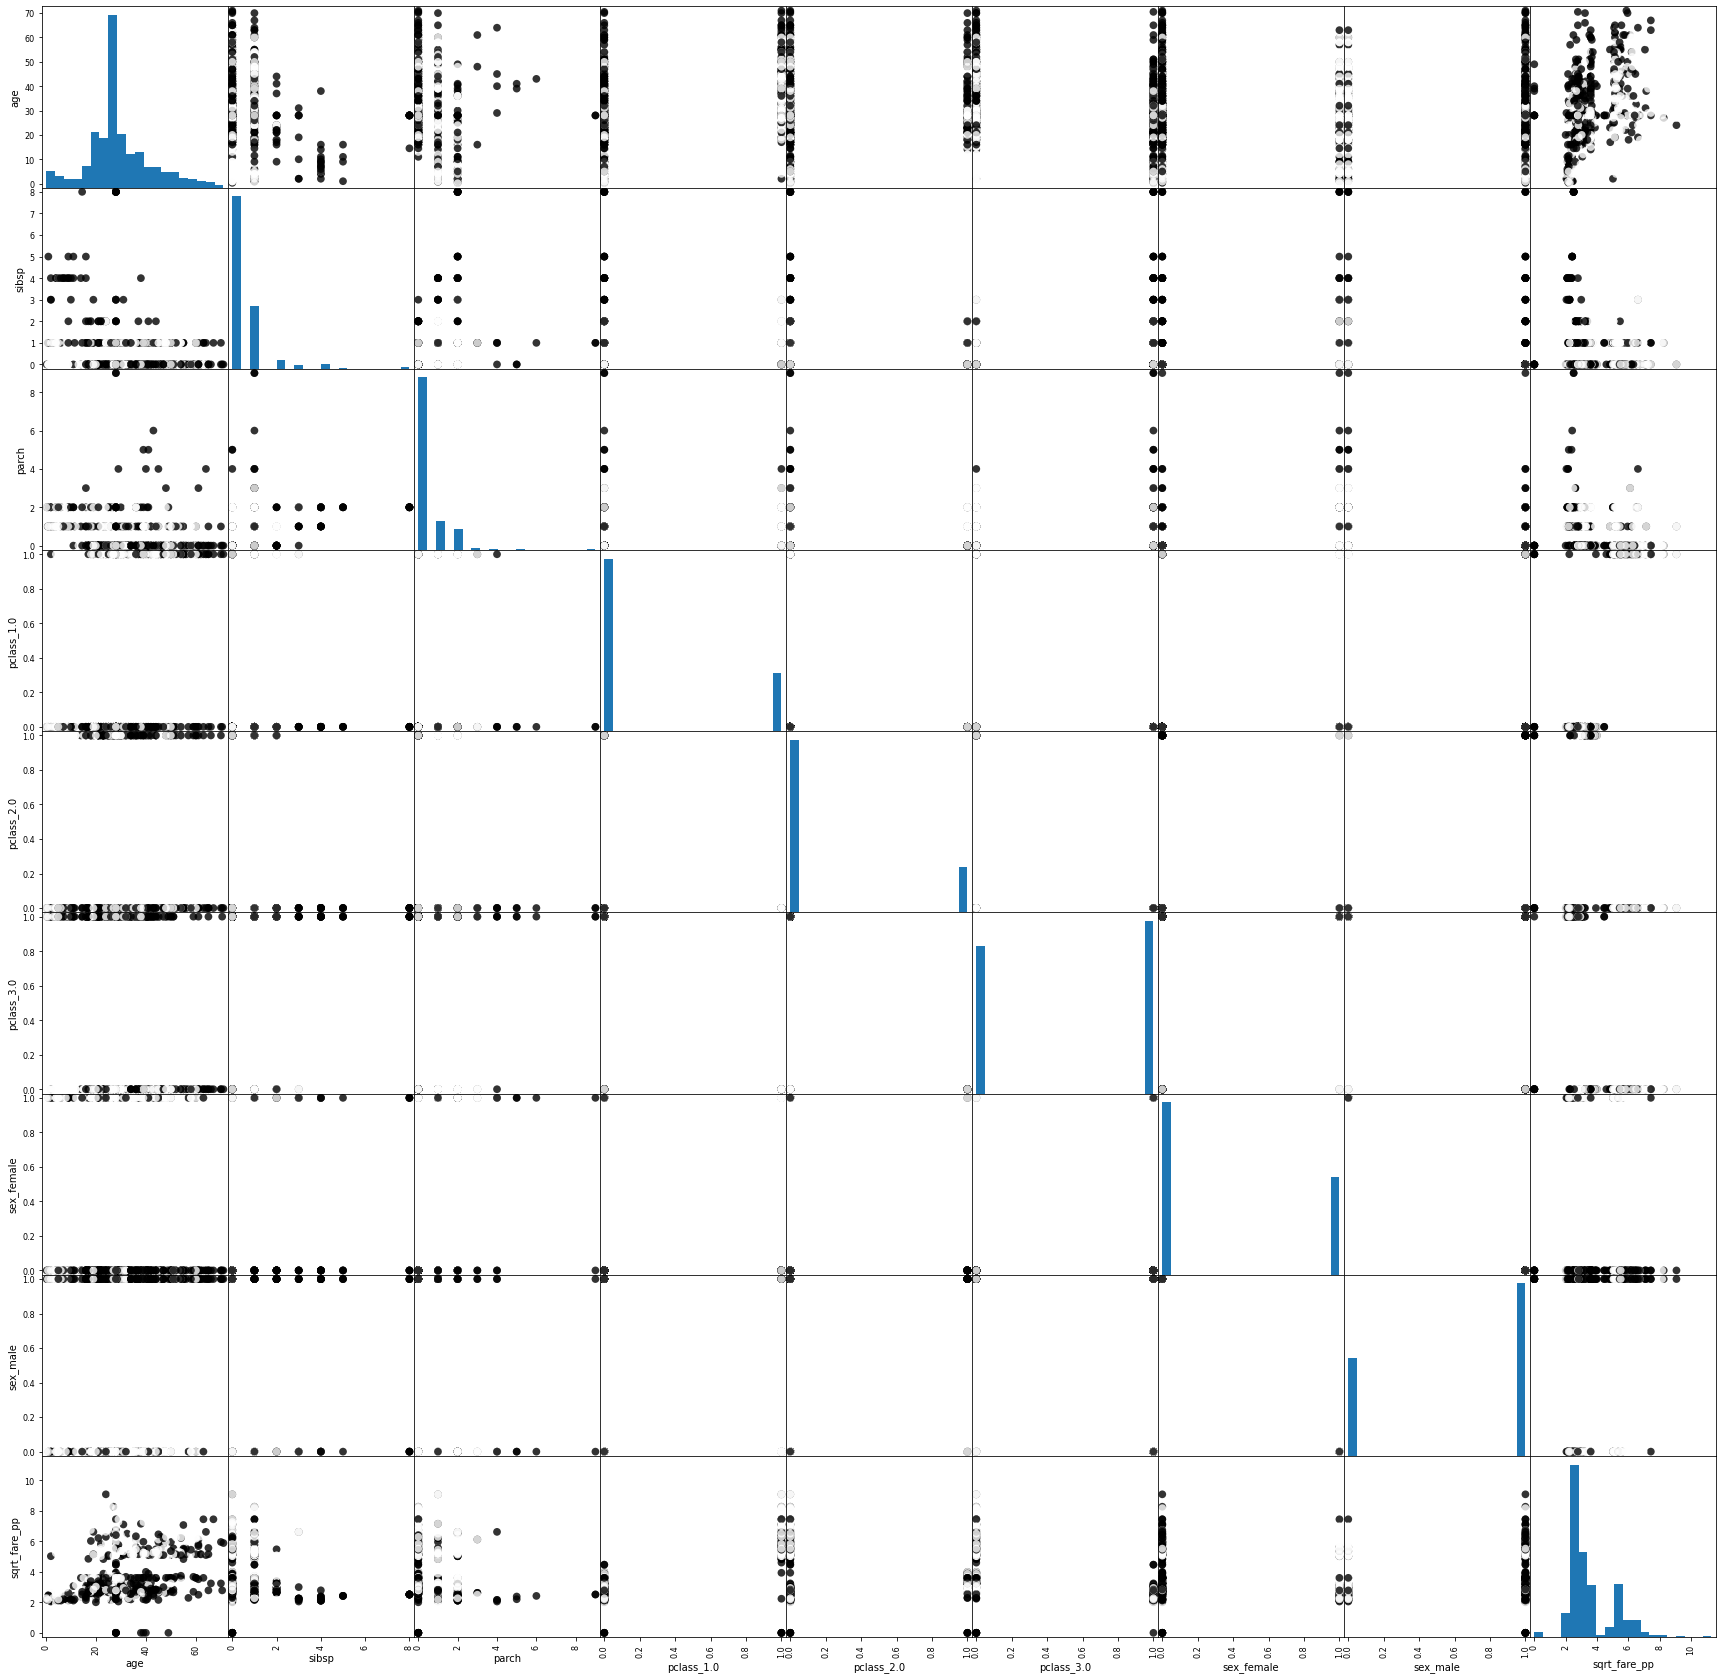

In [83]:
# plot all pairwise comparisons
# just to try

pd.plotting.scatter_matrix(X_train, c=y_train, figsize=(30,30),
                          marker='o', hist_kwds={'bins':20}, s=60, alpha=0.8)
# hm, doesn't seem that informative

## Conclusions so far

1. Gradient-boosted decision tree could reach 0.81 prediction accuracy.<br>
(Doesn't seem like the best possible score, I guess there's lots of scope to improve)<br>

    Learning_rate=0.01, max_depth=3<br>
    Train score is 0.81 and Test score is 0.81.<br><br>
    clf.feature_importances_ [0.0592755  0.05390956 0.01021982 0.         0.         0.15193778
     0.29342463 0.35228386 0.07894885]<br>
     => is_male is most important, then is_woman, then is_3rd_class
